### Workflow for analyzing a database with more than 1000 datasets https://zenodo.org/records/7118947


It took 1230 seconds to compute all orders (from pairs to N) for:
* batch_size = 100000. Used only  datasets with 20 or less variables 
* In a 12th Gen Intel© Core™ i9-12900H × 14
* Linux mint 20.3
* Using les than 8 GB of RAM

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import time
from pathlib import Path

# Import THOI library functions
from thoi.measures.gaussian_copula import multi_order_measures

# Import sklearn functions for PCA and data scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Define the data folder and filename
data_folder = Path('../data/')
filename = 'database_zenodo.pkl'

# Load the data from the pickle file
data_path = data_folder / filename
data_obj = pd.read_pickle(data_path)

# Extract dataset names and data
dataset_names = list(data_obj.keys())  # Names of each dataset
dataset_data = [data_obj[name]['data'] for name in dataset_names]  # Data of each dataset

# Calculate system sizes
system_sizes = np.array([data.shape[0] for data in dataset_data])  # System size

# Filter datasets with 20 or fewer variables
max_size = 20
valid_indices = np.where(system_sizes <= max_size)[0]
filtered_data = [dataset_data[idx] for idx in valid_indices]
filtered_names = [dataset_names[idx] for idx in valid_indices]

# Print the number of filtered datasets
print(f'Number of datasets {len(filtered_data)}')

print('Number of datasets per size')
for size, count in zip(*np.unique([np.shape(x)[0] for x in filtered_data], return_counts=True)):
    print('\tsize:', size,'\tamount:', count)

Number of datasets 920
Number of datasets per size
	size: 5 	amount: 173
	size: 6 	amount: 235
	size: 7 	amount: 20
	size: 8 	amount: 5
	size: 9 	amount: 45
	size: 10 	amount: 210
	size: 11 	amount: 8
	size: 12 	amount: 7
	size: 13 	amount: 8
	size: 14 	amount: 13
	size: 15 	amount: 43
	size: 16 	amount: 30
	size: 17 	amount: 11
	size: 18 	amount: 5
	size: 19 	amount: 13
	size: 20 	amount: 94


In [ ]:
# NOTE: comment this block to avoid reprocessing already processed data
# Computing high order interactions exhaustively for all the system with maximum 20 variables
ini_time = time.time()
batch_size = 100000
output = [multi_order_measures(x.T, min_order=2, batch_size=batch_size) for x in filtered_data]
final_time = (time.time() - ini_time)
print(f'Total processing time for {len(filtered_data)} == {final_time} seconds')

data_to_save = {
    "hoi_output": output,
    "data_names": filtered_names
}

# NOTE: uncomment this block to persist results to disk for later use
#Path("../results/920_datasets").mkdir(parents=True, exist_ok=True)
#with open('../results/920_datasets/hoi_output_full.pkl', 'wb') as f:
#    pickle.dump(data_to_save, f)

Total processing time for 920 == 1230.9081017971039 seconds


In [ ]:
# NOTE: uncomment this block to read already processed data
# Loading data
#output = pd.read_pickle('../results/920_datasets/hoi_output_full.pkl')

In [5]:
# Setting negative S, TC and DTC values, and -+inf to nan, and O-infor for order 2 to Nan
output_not_nan = [
    df.assign(tc=df['tc'].where(df['tc'] >= 0, np.nan),
              dtc=df['dtc'].where(df['dtc'] >= 0, np.nan),
              s=df['s'].where(df['s'] >= 0, np.nan),
              o=df['o'].where(df['order'] >= 3, np.nan))
    for df in output
]


In [6]:
# Computing pairwise metrics
mi_averages = pd.DataFrame([df['tc'][df['order']==2].mean(skipna=True) for df in output_not_nan], columns=['mean_mi'])
mi_stds = pd.DataFrame([df['tc'][df['order']==2].std(skipna=True) for df in output_not_nan], columns=['std_mi'])

/home/laouen.belloli/anaconda3/envs/thoi/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [7]:
# Extracting summary statistics for each dataset
# Extracting the Min, Max and Mean for each measure
mean_mes = pd.DataFrame([{col: df[col][df['order']>2].mean(skipna=True) for col in ['tc', 'dtc', 'o', 's']} for df in output_not_nan]).add_prefix('mean_')
max_mes = pd.DataFrame([{col: df[col][df['order']>2].max(skipna=True) for col in ['tc', 'dtc', 'o', 's']} for df in output_not_nan]).add_prefix('max_')
min_mes = pd.DataFrame([{col: df[col][df['order']>2].min(skipna=True) for col in ['tc', 'dtc', 'o', 's']} for df in output_not_nan]).add_prefix('min_')

min_o_index = pd.DataFrame([(df['order'].iloc[df['o'].idxmin(skipna=True)])/df['order'].iloc[-1] for df in output_not_nan], columns=['o_min_k/N'])
max_o_index = pd.DataFrame([(df['order'].iloc[df['o'].idxmax(skipna=True)])/df['order'].iloc[-1] for df in output_not_nan], columns=['o_max_k/N'])

o_below_zero = pd.DataFrame([(df['o'] < 0).sum() for df in output_not_nan], columns=['num syn-plets'])
o_above_zero = pd.DataFrame([(df['o'] > 0).sum() for df in output_not_nan], columns=['num red-plets'])
prop_syn_red = pd.DataFrame([((df['o'] < 0).sum())/((df['o'] > 0).sum() + (df['o'] < 0).sum()) for df in output_not_nan], columns=['prop. syn-plets'])
prop_syn_red = prop_syn_red.replace([np.inf, -np.inf], np.nan)

whole_meas = pd.DataFrame([{col: df[col].iloc[-1] for col in ['tc', 'dtc', 'o', 's']} for df in output_not_nan]).add_prefix('whole_')

sys_size = pd.DataFrame(data=[np.shape(x)[0] for x in filtered_data], columns=['N'])


combined_df = pd.concat([whole_meas, mean_mes, max_mes, min_mes, mi_averages, 
                         mi_stds, min_o_index, max_o_index, prop_syn_red, sys_size,  
                        pd.DataFrame(data=filtered_names, columns=['name'])], axis=1)

# Replacing infs with nans and removing rows with nans
combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df_not_nan = combined_df.dropna()

### Plotting results


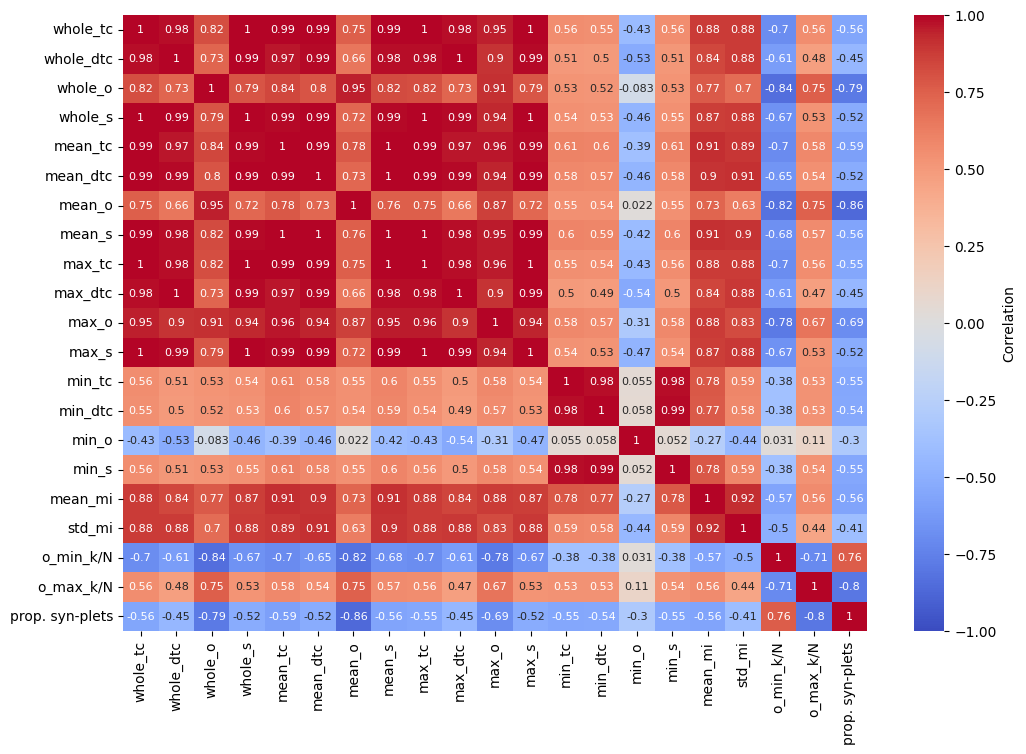

In [8]:

# Computing correlation between features
data_cols = combined_df_not_nan.columns[:-2]
correlation_matrix = combined_df_not_nan[data_cols].corr(method='spearman')

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix,
            vmin=-1, vmax=1, cmap='coolwarm',
            annot=True, annot_kws={'fontsize': 8},
            cbar_kws={'label': 'Correlation'})
plt.show()

### Principal component analysis of features across datasets

In [9]:
# PCA on features
# Standardize the data if needed
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df_not_nan[data_cols])
# scaled_data = combined_df_not_nan[data_cols]

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)


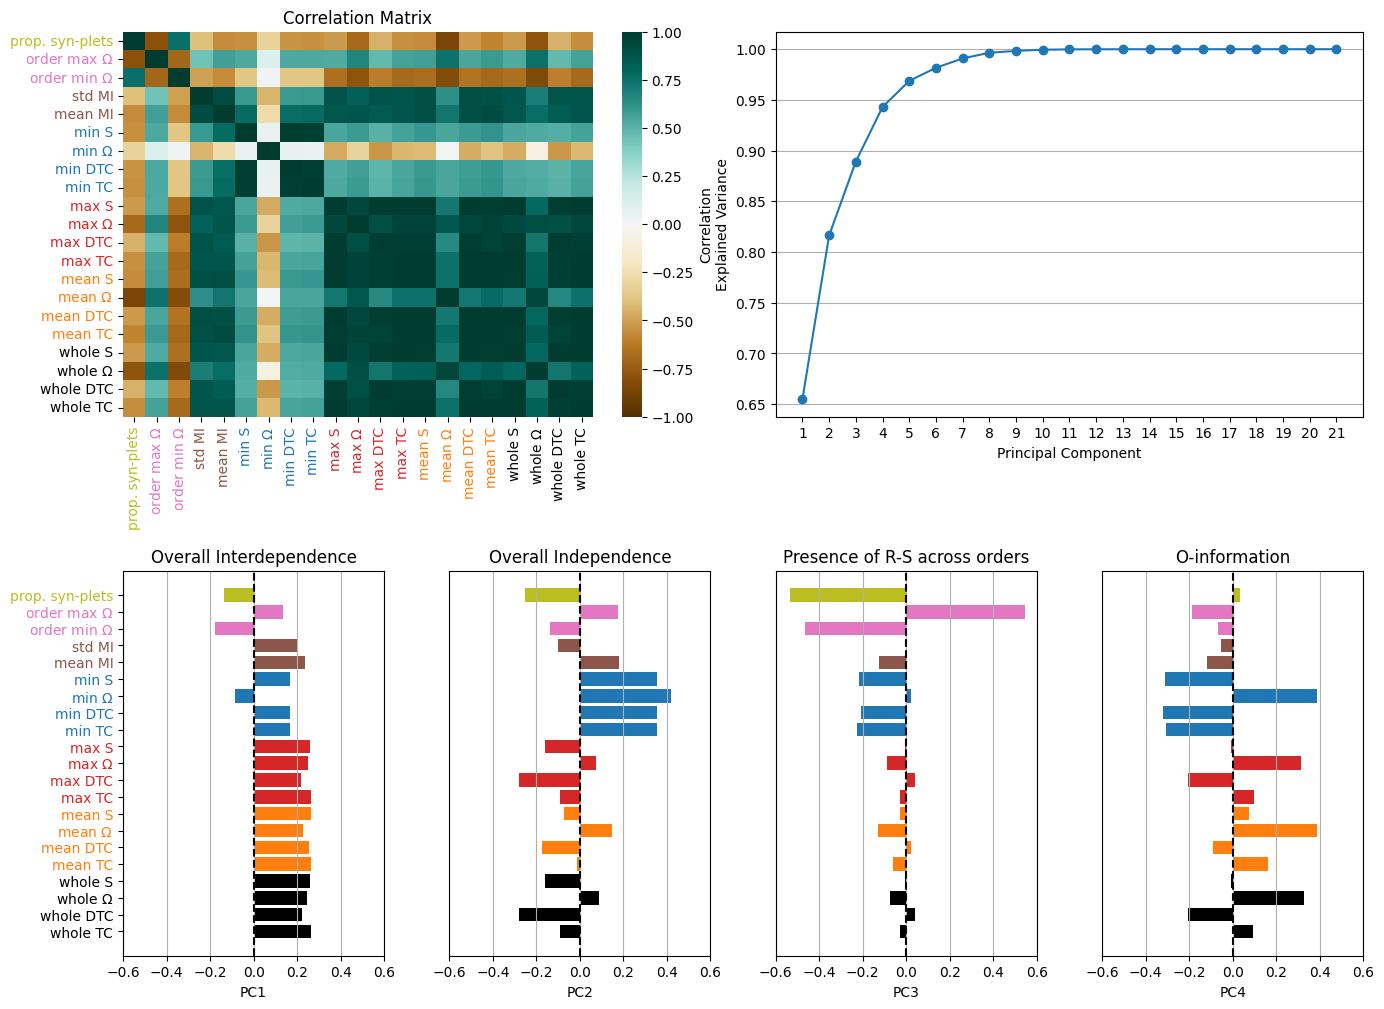

In [12]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Define titles and parameters
pc_titles = [
    'Overall Interdependence',
    'Overall Independence',
    'Presence of R-S across orders',
    'O-information'
]
col_names = ['whole TC','whole DTC',
    'whole $\\Omega$',
    'whole S','mean TC','mean DTC','mean $\\Omega$','mean S','max TC',
    'max DTC','max $\\Omega$','max S','min TC','min DTC','min $\\Omega$',
    'min S','mean MI','std MI','order min $\\Omega$','order max $\\Omega$','prop. syn-plets'
]

correlation_matrix.columns = col_names
correlation_matrix.index = col_names

ncols = len(col_names)
npcs = 4
explained_variance = pca.explained_variance_ratio_
pc_basis = pca.components_[:npcs]
cols_colors = plt.get_cmap('tab10')(np.linspace(0, 1, 7))

bar_colors = []
for name in col_names:
    if name.endswith('MI'):
        bar_colors.append(cols_colors[3])
    elif name.startswith('mean'):
        bar_colors.append(cols_colors[1])
    elif name.startswith('min'):
        bar_colors.append(cols_colors[0])
    elif name.startswith('max'):
        bar_colors.append(cols_colors[2])
    elif name.startswith('order'):
        bar_colors.append(cols_colors[4])
    elif name.startswith('prop.'):
        bar_colors.append(cols_colors[5])
    else:
        bar_colors.append('black')  # default color


fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 4, height_ratios=[1, 1], hspace=0.4, wspace=0.25)

# First row: Correlation matrix
ax_corr = fig.add_subplot(gs[0, 0:2])
sns.heatmap(
    correlation_matrix, vmin=-1, vmax=1, cmap='BrBG',
    annot=False, cbar_kws={'label': 'Correlation'}, ax=ax_corr, xticklabels=col_names, yticklabels=col_names,
)
ax_corr.invert_yaxis()
ax_corr.invert_xaxis()

ax_corr.set_title('Correlation Matrix')
for label in ax_corr.get_yticklabels():
    text = label.get_text()
    if text.endswith('MI'):
        label.set_color(cols_colors[3])
    elif text.startswith('mean'):
        label.set_color(cols_colors[1])
    elif text.startswith('min'):
        label.set_color(cols_colors[0])
    elif text.startswith('max'): 
        label.set_color(cols_colors[2])
    elif text.startswith('order'):
        label.set_color(cols_colors[4])
    elif text.startswith('prop.'):
        label.set_color(cols_colors[5])

for label in ax_corr.get_xticklabels():
    text = label.get_text()
    if text.endswith('MI'):
        label.set_color(cols_colors[3])
    elif text.startswith('mean'):
        label.set_color(cols_colors[1])
    elif text.startswith('min'):
        label.set_color(cols_colors[0])
    elif text.startswith('max'): 
        label.set_color(cols_colors[2])
    elif text.startswith('order'):
        label.set_color(cols_colors[4])
    elif text.startswith('prop.'):
        label.set_color(cols_colors[5])

# First row: Explained variance
ax_var = fig.add_subplot(gs[0, 2:4])
ax_var.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='-')
ax_var.set_xlabel('Principal Component')
ax_var.set_ylabel('Explained Variance')
ax_var.set_xticks(np.arange(1, len(explained_variance) + 1, 1))
ax_var.grid(axis='y')

# Second row: Principal components loadings
axes_pc = []
for i in range(npcs):
    ax = fig.add_subplot(gs[1, i])
    ax.barh(np.arange(ncols), pc_basis[i], color=bar_colors)
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel(f'PC{i + 1}')
    ax.set_xlim([-0.6, 0.6])
    ax.grid(axis='x')
    ax.set_title(pc_titles[i])
    if i != 0:
        ax.set_yticks([])
    else:
        ax.set_yticks(np.arange(ncols))
        ax.set_yticklabels(col_names)
    

    for label in ax.get_yticklabels():
        text = label.get_text()
        if text.endswith('MI'):
            label.set_color(cols_colors[3])
        elif text.startswith('mean'):
            label.set_color(cols_colors[1])
        elif text.startswith('min'):
            label.set_color(cols_colors[0])
        elif text.startswith('max'): 
            label.set_color(cols_colors[2])
        elif text.startswith('order'):
            label.set_color(cols_colors[4])
        elif text.startswith('prop.'):
            label.set_color(cols_colors[5])

plt.show()